## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
torch.__version__

'2.8.0+cu126'

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

source_path = "/content/drive/MyDrive/Deep Learning/Data/playground-series-s4e8.zip"
dest_path = "/content/data.zip"

shutil.copy(source_path, dest_path)
print("✅ File copied to Colab temporary storage.")

✅ File copied to Colab temporary storage.


In [ ]:
import zipfile

with zipfile.ZipFile(dest_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")
print("✅ File extracted successfully.")

✅ File extracted successfully.


In [ ]:
import os

os.remove("/content/data.zip")
print("✅ ZIP file deleted successfully.")

✅ ZIP file deleted successfully.


In [ ]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [ ]:
df_train = df_train.drop(columns=['id'])

In [ ]:
num_samples, num_features = df_train.shape
num_features -= 1
num_classes = len(np.unique(df_train['class']))
num_samples, num_features, num_classes

(3116945, 20, 2)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   class                 object 
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), object(18)
memory usage: 499.4+ MB


In [ ]:
df_train, df_valid = train_test_split(df_train, train_size=0.8, random_state=10, stratify=df_train['class'])
len(df_train), len(df_valid)

(2493556, 623389)

## Preprocessing

In [ ]:
df_train.isna().sum()

,0
class,0
cap-diameter,3
cap-shape,35
cap-surface,536732
cap-color,9
does-bruise-or-bleed,7
gill-attachment,418810
gill-spacing,1006476
gill-color,47
stem-height,0


In [ ]:
df_train.isna().mean() * 100

,0
class,0.000000
cap-diameter,0.000120
cap-shape,0.001404
cap-surface,21.524762
cap-color,0.000361
does-bruise-or-bleed,0.000281
gill-attachment,16.795693
gill-spacing,40.363080
gill-color,0.001885
stem-height,0.000000


In [ ]:
missing_threshhold = 0.50

high_missing_columns = df_train.columns[df_train.isna().mean() > missing_threshhold]
print(high_missing_columns)
df_train.isna().mean() > missing_threshhold

Index(['stem-root', 'stem-surface', 'veil-type', 'veil-color',
       'spore-print-color'],
      dtype='object')


,0
class,False
cap-diameter,False
cap-shape,False
cap-surface,False
cap-color,False
does-bruise-or-bleed,False
gill-attachment,False
gill-spacing,False
gill-color,False
stem-height,False


In [ ]:
df_train = df_train.drop(columns=high_missing_columns)
df_valid = df_valid.drop(columns=high_missing_columns)

print(len(df_train))
df_train.head()

2493556


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
2256566,p,3.30,c,NaN,u,f,a,c,n,3.76,3.50,u,f,f,d,a
2032804,e,3.04,s,NaN,n,f,f,f,f,5.79,7.15,y,f,f,d,a
350767,e,6.32,x,t,n,f,e,NaN,w,12.86,12.36,n,f,f,d,u
402889,e,0.97,c,g,n,t,a,NaN,p,5.14,0.97,n,f,f,h,u
946147,e,3.54,b,g,n,f,a,d,g,5.89,3.60,g,f,f,d,u


In [ ]:
df_train.mode()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,p,1.49,x,t,n,f,a,c,w,5.24,2.41,w,f,f,d,a


In [ ]:
mode_values = df_train.mode()
mode_values = mode_values.loc[0].to_dict()
mode_values

{'class': 'p',
 'cap-diameter': 1.49,
 'cap-shape': 'x',
 'cap-surface': 't',
 'cap-color': 'n',
 'does-bruise-or-bleed': 'f',
 'gill-attachment': 'a',
 'gill-spacing': 'c',
 'gill-color': 'w',
 'stem-height': 5.24,
 'stem-width': 2.41,
 'stem-color': 'w',
 'has-ring': 'f',
 'ring-type': 'f',
 'habitat': 'd',
 'season': 'a'}

In [ ]:
mode_values['cap-shape']

'x'

In [ ]:
median_values = df_train.median(numeric_only=True).to_dict()
median_values

{'cap-diameter': 5.75, 'stem-height': 5.88, 'stem-width': 9.65}

In [ ]:
for column in df_train.columns:
    if df_train[column].isna().any():
        # print(column)
        if df_train[column].dtype == 'object':
            df_train[column] = df_train[column].fillna(mode_values[column])
            df_valid[column] = df_valid[column].fillna(mode_values[column])
        else:
            df_train[column] = df_train[column].fillna(median_values[column])
            df_valid[column] = df_valid[column].fillna(median_values[column])

In [ ]:
df_train.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
2256566,p,3.30,c,t,u,f,a,c,n,3.76,3.50,u,f,f,d,a
2032804,e,3.04,s,t,n,f,f,f,f,5.79,7.15,y,f,f,d,a
350767,e,6.32,x,t,n,f,e,c,w,12.86,12.36,n,f,f,d,u
402889,e,0.97,c,g,n,t,a,c,p,5.14,0.97,n,f,f,h,u
946147,e,3.54,b,g,n,f,a,d,g,5.89,3.60,g,f,f,d,u


In [ ]:
df_train.isna().any()

,0
class,False
cap-diameter,False
cap-shape,False
cap-surface,False
cap-color,False
does-bruise-or-bleed,False
gill-attachment,False
gill-spacing,False
gill-color,False
stem-height,False


### Encoding

In [ ]:
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

cat_col_train = df_train.select_dtypes(include=['object']).columns
cat_col_train = [c for c in cat_col_train if c != 'class']
print(cat_col_train)

df_train[cat_col_train] = ordinal_encoder.fit_transform(df_train[cat_col_train].astype(str))
df_valid[cat_col_train] = ordinal_encoder.transform(df_valid[cat_col_train].astype(str))

df_train.head()

['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
2256566,p,3.30,39.0,66.0,61.0,6.0,37.0,23.0,40.0,3.76,3.50,47.0,3.0,14.0,21.0,0.0
2032804,e,3.04,56.0,66.0,52.0,6.0,44.0,28.0,30.0,5.79,7.15,50.0,3.0,14.0,21.0,0.0
350767,e,6.32,60.0,66.0,52.0,6.0,43.0,23.0,51.0,12.86,12.36,39.0,3.0,14.0,21.0,2.0
402889,e,0.97,39.0,46.0,52.0,18.0,37.0,23.0,42.0,5.14,0.97,39.0,3.0,14.0,26.0,2.0
946147,e,3.54,37.0,46.0,52.0,6.0,37.0,25.0,31.0,5.89,3.60,31.0,3.0,14.0,21.0,2.0


In [ ]:
df_train['cap-color'].value_counts()

,count
cap-color,
52.0,1087174
65.0,309233
63.0,303931
46.0,168472
44.0,157902
...,...
35.0,1
43.0,1
3.0,1


In [ ]:
df_train['class'].value_counts()

,count
class,
p,1364317
e,1129239


## Pytorch

In [ ]:
X_train = df_train.drop(['class'], axis=1).values
y_train = df_train["class"].map({"e": 0, "p": 1}).values.reshape(-1, 1)
# y_train = df_train['class'].values.reshape(-1, 1)

X_valid = df_valid.drop(['class'], axis=1).values
y_valid = df_valid["class"].map({"e": 0, "p": 1}).values.reshape(-1, 1)
# y_valid = df_valid['class'].values.reshape(-1, 1)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2493556, 15), (2493556, 1), (623389, 15), (623389, 1))

In [ ]:
x_scaler = StandardScaler()
X_train = x_scaler.fit_transform(X_train)
X_valid = x_scaler.transform(X_valid)

In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_valid = torch.tensor(X_valid, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

(torch.Size([2493556, 15]),
 torch.Size([2493556, 1]),
 torch.Size([623389, 15]),
 torch.Size([623389, 1]))

In [ ]:
train_set = TensorDataset(X_train, y_train)
valid_set = TensorDataset(X_valid, y_valid)

In [ ]:
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=256)

In [ ]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([256, 15]), torch.Size([256, 1]))

## Model

In [ ]:
num_samples, num_features = X_train.shape
num_samples, num_features

(2493556, 15)

In [ ]:
nf_hidden_layer1 = 4 * num_features
# nf_hidden_layer2 = 2 * nf_hidden_layer1
model = nn.Sequential(
    nn.Linear(in_features=num_features, out_features=nf_hidden_layer1),
    nn.ReLU(),
    # nn.Linear(in_features=nf_hidden_layer1, out_features=nf_hidden_layer2),
    # nn.ReLU(),
    nn.Linear(in_features=nf_hidden_layer1, out_features=1),
    nn.Sigmoid()
)
model = model.to(device)

In [ ]:
model(x_batch.to(device)).shape

torch.Size([256, 1])

In [ ]:
model[0].weight, model[0].bias

(Parameter containing:
 tensor([[-0.1936,  0.2319,  0.0272,  0.2458,  0.0935,  0.1383,  0.0623, -0.1223,
          -0.1173,  0.2222, -0.1457, -0.0295, -0.1545, -0.1361,  0.1763],
         [ 0.0999,  0.0540, -0.0923,  0.1912, -0.1726, -0.1974,  0.2565, -0.0393,
          -0.1862,  0.1152,  0.0111,  0.1068, -0.2486,  0.0485, -0.0115],
         [-0.0023, -0.0396, -0.1681, -0.1455, -0.0444, -0.1013, -0.1190, -0.1986,
          -0.0261, -0.0712,  0.1231, -0.1266, -0.0863, -0.1846,  0.0895],
         [-0.0003, -0.0720, -0.0761,  0.1784,  0.0444,  0.0738,  0.0854, -0.0511,
           0.0143, -0.0169,  0.1327, -0.0581, -0.0982,  0.1373,  0.0542],
         [ 0.2229,  0.2561,  0.2203,  0.0541, -0.2534,  0.2145, -0.1997, -0.0686,
           0.2050, -0.0785, -0.1065, -0.1699, -0.1957, -0.1177,  0.1675],
         [-0.2342, -0.1036, -0.1318, -0.0889,  0.1601,  0.0025,  0.0095,  0.1191,
           0.0446, -0.0574,  0.1171,  0.2104, -0.1659,  0.0432, -0.0739],
         [ 0.2235, -0.0356, -0.1277, -0.1

In [ ]:
model[0].weight.shape, model[0].bias.shape

(torch.Size([60, 15]), torch.Size([60]))

## Loss

In [ ]:
loss_fn = nn.BCELoss()
loss_fn

BCELoss()

## Optimizer

In [ ]:
optimizer = SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

## Train

In [ ]:
loss_train_hist, loss_valid_hist = [], []
acc_train_hist, acc_valid_hist = [], []
best_loss_valid = 10000

In [ ]:
epoch = 20

for epoch in range(epoch):
    mean_loss_train = mean_loss_valid = 0
    mean_acc_train = mean_acc_valid = 0

    for x_batch, y_batch in train_loader:
        # GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        # model
        y_hat = model(x_batch)
        # loss
        loss = loss_fn(y_hat, y_batch)
        # gradient
        loss.backward()
        # update
        optimizer.step()
        optimizer.zero_grad()

        mean_loss_train += loss.item() * len(x_batch)
        mean_acc_train += torch.sum(y_hat.round() == y_batch).item()

    mean_loss_train = mean_loss_train/len(train_set)
    mean_acc_train = mean_acc_train/len(train_set)

    loss_train_hist.append(mean_loss_train)
    acc_train_hist.append(mean_acc_train)

    with torch.no_grad():
        for x_batch, y_batch in valid_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_hat = model(x_batch)
            loss = loss_fn(y_hat, y_batch)
            mean_loss_valid += loss.item() * len(x_batch)
            mean_acc_valid += torch.sum(y_hat.round() == y_batch).item()

        mean_loss_valid = mean_loss_valid/len(valid_set)
        mean_acc_valid = mean_acc_valid/len(valid_set)

        loss_valid_hist.append(mean_loss_valid)
        acc_valid_hist.append(mean_acc_valid)

    print(
        f"Epoch: {epoch}    "
        f"LossTrain: {mean_loss_train:.2}    "
        f"AccTrain : {mean_acc_train:.2}    "
        f"LossValid: {mean_loss_valid:.2}    "
        f"AccValid : {mean_acc_valid:.2}    "
    )

    if mean_loss_valid < best_loss_valid:
        torch.save(model, "best-model.pt")
        best_loss_valid = mean_loss_valid
        print("Model Saved!")

Epoch: 0    LossTrain: 0.16    AccTrain : 0.95    LossValid: 0.16    AccValid : 0.96    
Model Saved!
Epoch: 1    LossTrain: 0.16    AccTrain : 0.96    LossValid: 0.16    AccValid : 0.96    
Model Saved!
Epoch: 2    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.96    
Model Saved!
Epoch: 3    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.96    
Model Saved!
Epoch: 4    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.96    
Model Saved!
Epoch: 5    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.96    
Model Saved!
Epoch: 6    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.96    
Model Saved!
Epoch: 7    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.96    
Model Saved!
Epoch: 8    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.96    
Model Saved!
Epoch: 9    LossTrain: 0.15    AccTrain : 0.96    LossValid: 0.15    AccValid : 0.

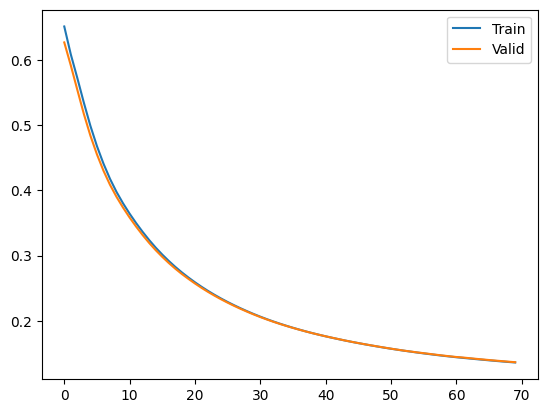

In [ ]:
n_epoch = len(loss_train_hist)
plt.plot(torch.arange(n_epoch), loss_train_hist)
plt.plot(torch.arange(n_epoch), loss_valid_hist)
plt.legend(["Train", "Valid"])

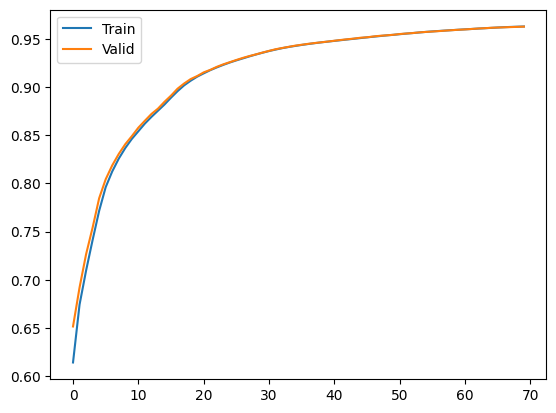

In [ ]:
plt.plot(torch.arange(n_epoch), acc_train_hist)
plt.plot(torch.arange(n_epoch), acc_valid_hist)
plt.legend(["Train", "Valid"])

## Test

In [ ]:
df_test = pd.read_csv('data/test.csv')
print(df_test.shape)
df_test.head()

(2077964, 21)


,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.64,x,NaN,n,t,NaN,NaN,w,11.13,...,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.90,o,t,o,f,NaN,c,y,1.27,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.00,b,g,n,f,NaN,c,n,6.18,...,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.47,x,t,n,f,s,c,n,4.98,...,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.17,x,h,y,f,p,NaN,y,6.73,...,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [ ]:
id_test = df_test["id"].copy()
cols_to_drop = ["id", "stem-root", "stem-surface", "veil-type", "veil-color", "spore-print-color"]
df_test = df_test.drop(columns=cols_to_drop)
df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,8.64,x,NaN,n,t,NaN,NaN,w,11.13,17.12,w,t,g,d,a
1,6.90,o,t,o,f,NaN,c,y,1.27,10.75,n,f,f,d,a
2,2.00,b,g,n,f,NaN,c,n,6.18,3.14,n,f,f,d,s
3,3.47,x,t,n,f,s,c,n,4.98,8.51,w,t,z,d,u
4,6.17,x,h,y,f,p,NaN,y,6.73,13.70,y,t,NaN,d,u


In [ ]:
for column in df_test.columns:
    if df_test[column].isna().any():
        if df_test[column].dtype == 'object':
            df_test[column] = df_test[column].fillna(mode_values[column])
        else:
            df_test[column] = df_test[column].fillna(median_values[column])

df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,8.64,x,t,n,t,a,c,w,11.13,17.12,w,t,g,d,a
1,6.90,o,t,o,f,a,c,y,1.27,10.75,n,f,f,d,a
2,2.00,b,g,n,f,a,c,n,6.18,3.14,n,f,f,d,s
3,3.47,x,t,n,f,s,c,n,4.98,8.51,w,t,z,d,u
4,6.17,x,h,y,f,p,c,y,6.73,13.70,y,t,f,d,u


In [ ]:
df_test[cat_col_train] = ordinal_encoder.transform(df_test[cat_col_train].astype(str))

In [ ]:
df_test.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,8.64,60.0,66.0,52.0,18.0,37.0,23.0,51.0,11.13,17.12,48.0,15.0,15.0,21.0,0.0
1,6.90,52.0,66.0,53.0,6.0,37.0,23.0,53.0,1.27,10.75,39.0,3.0,14.0,21.0,0.0
2,2.00,37.0,46.0,52.0,6.0,37.0,23.0,40.0,6.18,3.14,39.0,3.0,14.0,21.0,1.0
3,3.47,60.0,66.0,52.0,6.0,58.0,23.0,40.0,4.98,8.51,48.0,15.0,34.0,21.0,2.0
4,6.17,60.0,47.0,65.0,6.0,56.0,23.0,53.0,6.73,13.70,50.0,15.0,14.0,21.0,2.0


In [ ]:
for c in cat_col_train:
    print(c, df_test[c].nunique())

cap-shape 28
cap-surface 29
cap-color 27
does-bruise-or-bleed 20
gill-attachment 28
gill-spacing 17
gill-color 33
stem-color 27
has-ring 19
ring-type 29
habitat 27
season 4


In [ ]:
X_test = df_test.values
X_test = x_scaler.transform(X_test)

In [ ]:
X_test = torch.tensor(X_test, dtype=torch.float32)
X_test.shape

torch.Size([2077964, 15])

In [ ]:
test_set = TensorDataset(X_test)
test_loader = DataLoader(test_set, batch_size=4096, shuffle=False)

In [ ]:
model = torch.load("best-model.pt", weights_only=False, map_location=device)
model.to(device)
model.eval()

Sequential(
  (0): Linear(in_features=15, out_features=60, bias=True)
  (1): ReLU()
  (2): Linear(in_features=60, out_features=1, bias=True)
  (3): Sigmoid()
)

In [ ]:
all_preds = []

with torch.no_grad():
    for (x_batch,) in test_loader:
        x_batch = x_batch.to(device)
        y_hat = model(x_batch)

        all_preds.append(y_hat.cpu())

y_pred = torch.cat(all_preds, dim=0)
pred_labels = y_pred.round().int()

In [ ]:
pred_np = pred_labels.numpy().ravel()
mapped = ["p" if x == 1 else "e" for x in pred_np]

submission = pd.DataFrame({
    "id": id_test,
    "class": mapped
})

submission.to_csv("submission.csv", index=False)

In [ ]:
print(len(mapped))

2077964


In [ ]:
# train_cols = df_train.drop(columns=['class']).columns
# test_cols = df_test.columns

# print("only in train:", set(train_cols) - set(test_cols))
# print("only in test :", set(test_cols) - set(train_cols))
# print("same order? :", list(train_cols) == list(test_cols))

only in train: set()
only in test : set()
same order? : True
